### Inits

In [1]:
import sys
sys.path.append("..")

In [2]:
from balls import *

# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist


import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Data Read

In [4]:
hdul = fits.open('../data/DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=7.9
m_max=13
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=10
dec_max=50

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (dec > dec_min) & (dec < dec_max) & (ra > ra_min) & (ra < ra_max) & (z > z_min) 

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
DC_new=cosmo.comoving_distance(z_new)
DA_new=cosmo.angular_diameter_distance(z_new)
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = DC_new)



# Duty-cycle digitized
lam06=np.loadtxt(open('../../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

ValueError: A value in x_new is below the interpolation range.

### Functions and constants

In [6]:
theta_BH_const=(5*const.G*const.M_sun*u.rad/(const.c)**2).to(u.microarcsecond*u.Mpc)
def theta_BH(logM,DA):
    return theta_BH_const*10**logM/DA


# M_sig relation from Ho & Kormendy 2013 in units of km/sec
def MBH_to_sig(logM):
    return (10**(logM-9)/0.31)**(1/4.38)*200

grav_BH_const=(const.G*const.M_sun*u.rad/(u.km/u.s)**2).to(u.arcsecond*u.Mpc)
def grav_BH(logM,DA):
    return grav_BH_const*10**logM/DA/(MBH_to_sig(logM))**2

#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)

In [15]:
lis=np.linspace(0,4,1000)
DA_max=np.max(cosmo.angular_diameter_distance(lis)).value #Mpc
lis=lis[:np.argmax(cosmo.angular_diameter_distance(lis))]
DAt_lis=cosmo.angular_diameter_distance(lis).value
DCt_lis=cosmo.comoving_distance(lis)
DCt_lis=np.append(DCt_lis,cosmo.comoving_distance(lis[-1])).value
DAt_lis=np.append(DAt_lis,DA_max)
add_to_cmd=int1d(DAt_lis,DCt_lis)


In [16]:
## Try
rtest=np.loadtxt('../checks/rtest.csv',delimiter=',')
Dtest=np.loadtxt('../checks/Dtest.csv',delimiter=',')
DDtest=np.loadtxt('../checks/DDtest.csv',delimiter=',')
at,bt=co_vol_23(1,rtest,Dtest,DDtest)
np.sum(bt)/vol_1(1),np.sqrt(2*np.sum(at)/vol_1(1)+np.sum(bt)/vol_1(1)-(np.sum(bt)/vol_1(1))**2)

(3.8617722683127633, 1.5477916719407956)

In [23]:
# Find R_i for a given mass

# Fake D_A*theta[muas] list (i.e. it may be larger than D_A max)
fake_DA_theta=theta_BH(mass_new,u.Mpc)/u.microarcsecond
def Ri_theta(theta,Rmax):
    DA_temp=fake_DA_theta/theta # divide by theta to get the fake DA
    bol_temp=DA_temp>=DA_max # where is it larger than DA_max?
    DA_temp[bol_temp]=np.full(np.sum(bol_temp),DA_max) # replace the ones larger than DA_max by DA_max
    DC_temp=add_to_cmd(DA_temp) # convert DA-->DC
    bol_temp=DC_temp>Rmax # find which ones are larger than Rmax
    DC_temp[bol_temp]=np.full(np.sum(bol_temp),Rmax) # replace the ones larger than R_max by R_max
    return DC_temp

In [24]:
#Make cartsian
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)

In [25]:
QQ_dsit=cdist(QSO_car,QSO_car)

In [26]:
OBS_ball_pos=np.loadtxt('../data/ball_200_800_pos.csv',delimiter=',')
rmax=800#10**np.loadtxt('../../digi/ball_range_pos.csv',delimiter=',')[28]
robs=200
dist_lis=cdist(OBS_ball_pos,QSO_car)
rmax

800

In [27]:
len(dist_lis)

81

In [47]:
theta_logs=np.logspace(-2,2,30)


arr_theta_700=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_500=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_300=np.zeros((len(theta_logs),len(dist_lis)))
volt=vol_1(robs)
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,rmax)
    arr_theta_700[i]=np.array([np.sum(co_vol_2(robs,temp,j)[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,500)
    arr_theta_500[i]=np.array([np.sum(co_vol_2(robs,temp,j)[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,100)
    arr_theta_300[i]=np.array([np.sum(co_vol_2(robs,temp,j)[0]) for j in (dist_lis)])/volt



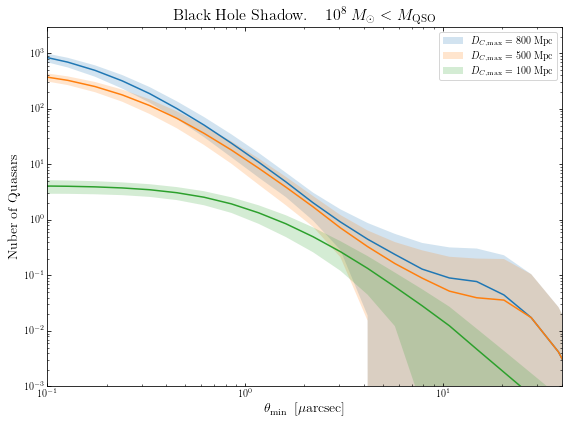

In [48]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=800\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=100\;\rm{Mpc}$')

plt.xlim(.1,40)
plt.ylim(.001,3*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu{\rm arcsec}\right]$', fontsize=14)

plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('../figs/shad_tot_all.pdf')

plt.show()

In [49]:
theta_logs=np.logspace(-2,2,30)

mass_inds=mass_new<10.5

dist_lis_less=dist_lis
arr_theta_700=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_500=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_300=np.zeros((len(theta_logs),len(dist_lis)))
volt=vol_1(robs)
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,rmax)[mass_inds]
    arr_theta_700[i]=np.array([np.sum(co_vol_2(robs,temp,j[mass_inds])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,500)[mass_inds]
    arr_theta_500[i]=np.array([np.sum(co_vol_2(robs,temp,j[mass_inds])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,100)[mass_inds]
    arr_theta_300[i]=np.array([np.sum(co_vol_2(robs,temp,j[mass_inds])[0]) for j in (dist_lis)])/volt



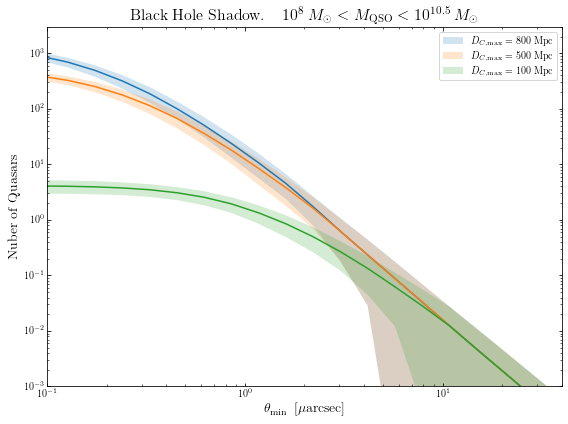

In [50]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=800\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=100\;\rm{Mpc}$')

plt.xlim(.1,40)
plt.ylim(.001,3*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu{\rm arcsec}\right]$', fontsize=14)

plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}<10^{10.5}\;M_\odot$', fontsize=16)




ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/shad_tot_limited.pdf')


plt.show()

In [32]:
volvol=vol_1(robs)
N_rmax=np.zeros(len(theta_logs))
S_rmax=np.zeros(len(theta_logs))
N_temp=np.zeros(len(dist_lis))
S_temp=np.zeros(len(dist_lis))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,100)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    temp=Ri_theta(x,500)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    temp=Ri_theta(x,800)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    

KeyboardInterrupt: 

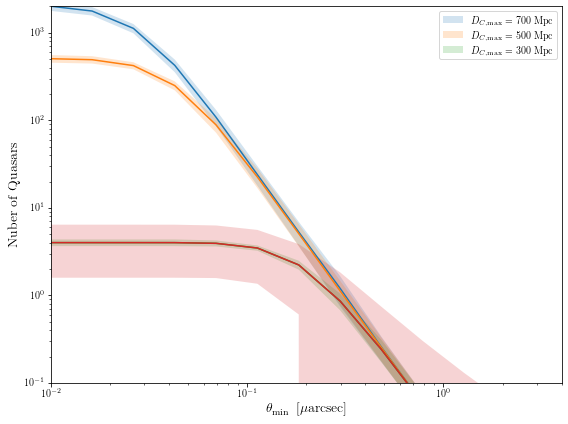

In [31]:
ig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=700\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=300\;\rm{Mpc}$')

ax.loglog(theta_logs,N_rmax)
ax.fill_between(theta_logs,N_rmax+S_rmax,N_rmax-S_rmax,alpha=0.2)

plt.xlim(.01,4)
plt.ylim(.1,2*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu{\rm arcsec}\right]$', fontsize=14)

ax.legend(loc='upper right',fontsize=10) 

plt.show()

# Distance

In [42]:
OBS_ball_pos=np.loadtxt('../data/ball_200_1000_pos.csv',delimiter=',')
rmax=1000
dist_logs=np.logspace(0,np.log10(rmax),25)
robs=200


volt=vol_1(robs)

arr_dist_p1=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_1=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_10=np.zeros((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    tempp1=Ri_theta(.1,x)
    temp1=Ri_theta(1,x)
    temp10=Ri_theta(10,x)
    arr_dist_p1[i]=np.array([np.sum(co_vol_2(robs,tempp1,j)[0]) for j in (dist_lis)])/volt
    arr_dist_1[i]=np.array([np.sum(co_vol_2(robs,temp1,j)[0]) for j in (dist_lis)])/volt
    arr_dist_10[i]=np.array([np.sum(co_vol_2(robs,temp10,j)[0]) for j in (dist_lis)])/volt
    

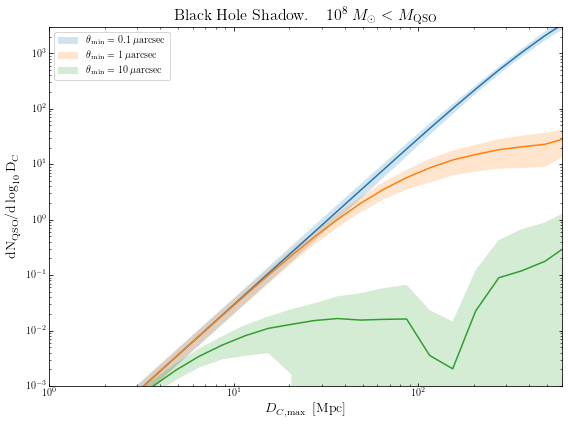

In [43]:
dd=np.diff(np.log10(dist_logs))[0]
dist_logs_diff=np.sqrt(dist_logs[1:]*dist_logs[:-1])
arr_diff_dist_p1=np.diff(arr_dist_p1,axis=0)/dd
arr_diff_dist_1=np.diff(arr_dist_1,axis=0)/dd
arr_diff_dist_10=np.diff(arr_dist_10,axis=0)/dd


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)



ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1)+np.std(arr_diff_dist_p1,axis=1),np.mean(arr_diff_dist_p1,axis=1)-np.std(arr_diff_dist_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\mu{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1)+np.std(arr_diff_dist_1,axis=1),np.mean(arr_diff_dist_1,axis=1)-np.std(arr_diff_dist_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\mu{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_10,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_10,axis=1)+np.std(arr_diff_dist_10,axis=1),np.mean(arr_diff_dist_10,axis=1)-np.std(arr_diff_dist_10,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=10\;\mu{\rm arcsec}$')



plt.xlim(1,600)
plt.ylim(10**(-3),3*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)
plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)

ax.legend(loc='upper left',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/shad_dNdD_all.pdf')


plt.show()

In [44]:
OBS_ball_pos=np.loadtxt('../data/ball_200_1000_pos.csv',delimiter=',')
rmax=1000
dist_logs=np.logspace(0,np.log10(rmax),25)
robs=200


volt=vol_1(robs)

arr_dist_p1=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_1=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_10=np.zeros((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    tempp1=Ri_theta(.1,x)[mass_inds]
    temp1=Ri_theta(1,x)[mass_inds]
    temp10=Ri_theta(10,x)[mass_inds]
    arr_dist_p1[i]=np.array([np.sum(co_vol_2(robs,tempp1,j[mass_inds])[0]) for j in (dist_lis)])/volt
    arr_dist_1[i]=np.array([np.sum(co_vol_2(robs,temp1,j[mass_inds])[0]) for j in (dist_lis)])/volt
    arr_dist_10[i]=np.array([np.sum(co_vol_2(robs,temp10,j[mass_inds])[0]) for j in (dist_lis)])/volt
    

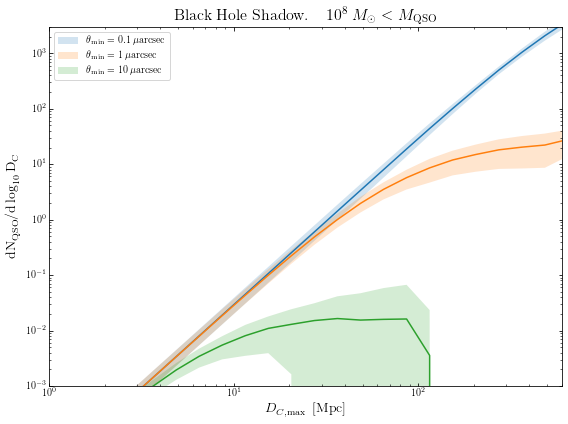

In [45]:
dd=np.diff(np.log10(dist_logs))[0]
dist_logs_diff=np.sqrt(dist_logs[1:]*dist_logs[:-1])
arr_diff_dist_p1=np.diff(arr_dist_p1,axis=0)/dd
arr_diff_dist_1=np.diff(arr_dist_1,axis=0)/dd
arr_diff_dist_10=np.diff(arr_dist_10,axis=0)/dd


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)



ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1)+np.std(arr_diff_dist_p1,axis=1),np.mean(arr_diff_dist_p1,axis=1)-np.std(arr_diff_dist_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\mu{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1)+np.std(arr_diff_dist_1,axis=1),np.mean(arr_diff_dist_1,axis=1)-np.std(arr_diff_dist_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\mu{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_10,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_10,axis=1)+np.std(arr_diff_dist_10,axis=1),np.mean(arr_diff_dist_10,axis=1)-np.std(arr_diff_dist_10,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=10\;\mu{\rm arcsec}$')



plt.xlim(1,600)
plt.ylim(10**(-3),3*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)
plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)

ax.legend(loc='upper left',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/shad_dNdD_limited.pdf')


plt.show()

# Mass function

In [46]:
mass_bins=np.linspace(np.min(mass_new),np.max(mass_new),25)
OBS_ball_pos=np.loadtxt('../data/ball_200_700_pos.csv',delimiter=',')
rmax=700
robs=200
volt=vol_1(robs)


arr_mass_10=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_1=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_p1=np.zeros((len(mass_bins),len(dist_lis)))


for i,x in enumerate(tqdm(mass_bins[1:])):
    tind=(mass_new>mass_bins[i]) & (mass_new<x)
    temp=Ri_theta(10,rmax)[tind]
    arr_mass_10[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(1,rmax)[tind]
    arr_mass_1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(.1,rmax)[tind]
    arr_mass_p1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    

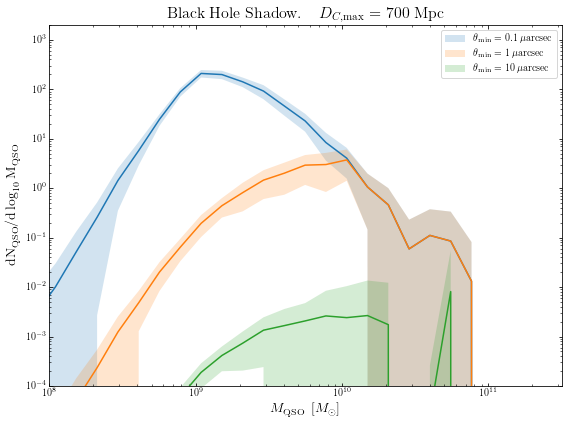

In [51]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)



ax.loglog(10**mass_bins,np.mean(arr_mass_p1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_p1,axis=1)+np.std(arr_mass_p1,axis=1),np.mean(arr_mass_p1,axis=1)-np.std(arr_mass_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\mu\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_1,axis=1)+np.std(arr_mass_1,axis=1),np.mean(arr_mass_1,axis=1)-np.std(arr_mass_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\mu\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_10,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_10,axis=1)+np.std(arr_mass_10,axis=1),np.mean(arr_mass_10,axis=1)-np.std(arr_mass_10,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=10\;\mu\rm{arcsec}$')


plt.xlim(10**8,10**11.5)
plt.ylim(10**(-4),2*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}M_{\rm QSO}}$', fontsize=14)
plt.xlabel(r'$M_{\rm QSO}\;\left[M_\odot\right]$', fontsize=14)

plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;D_{C,\rm{max}}=700\;\rm Mpc$', fontsize=16)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/shad_dNdM_all.pdf')

plt.show()

In [52]:
mass_bins=np.linspace(np.min(mass_new),np.max(mass_new),25)
OBS_ball_pos=np.loadtxt('../data/ball_200_700_pos.csv',delimiter=',')
rmax=700
robs=200
volt=vol_1(robs)


arr_mass_10=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_1=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_p1=np.zeros((len(mass_bins),len(dist_lis)))


for i,x in enumerate(tqdm(mass_bins[1:-6])):
    tind=(mass_new>mass_bins[i]) & (mass_new<x)
    temp=Ri_theta(10,rmax)[tind]
    arr_mass_10[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(1,rmax)[tind]
    arr_mass_1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(.1,rmax)[tind]
    arr_mass_p1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    

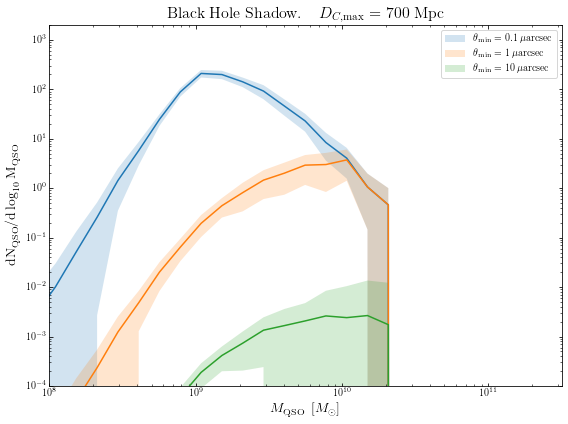

In [53]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)



ax.loglog(10**mass_bins,np.mean(arr_mass_p1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_p1,axis=1)+np.std(arr_mass_p1,axis=1),np.mean(arr_mass_p1,axis=1)-np.std(arr_mass_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\mu\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_1,axis=1)+np.std(arr_mass_1,axis=1),np.mean(arr_mass_1,axis=1)-np.std(arr_mass_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\mu\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_10,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_10,axis=1)+np.std(arr_mass_10,axis=1),np.mean(arr_mass_10,axis=1)-np.std(arr_mass_10,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=10\;\mu\rm{arcsec}$')


plt.xlim(10**8,10**11.5)
plt.ylim(10**(-4),2*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}M_{\rm QSO}}$', fontsize=14)
plt.xlabel(r'$M_{\rm QSO}\;\left[M_\odot\right]$', fontsize=14)

plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;D_{C,\rm{max}}=700\;\rm Mpc$', fontsize=16)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/shad_dNdM_limited.pdf')

plt.show()